In [1]:
!pip install kaggle 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [3]:
!mkdir ~/.kaggle
!cp /content/gdrive/MyDrive/kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!cat ~/.kaggle/kaggle.json

{"username":"moz11251125","key":"8183ea8d0c71783475762374aebfa916"}

In [5]:
!kaggle datasets download -d williamscott701/memotion-dataset-7k

100% 694M/695M [00:34<00:00, 21.1MB/s]
100% 695M/695M [00:34<00:00, 21.3MB/s]


In [6]:
!unzip -qq /content/memotion-dataset-7k.zip

In [7]:
import re
import string
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPool2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Activation, Dropout
from tensorflow.keras.layers import Conv1D, Embedding, GlobalAveragePooling1D 
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.preprocessing import image


In [8]:
df = pd.read_csv('/content/memotion_dataset_7k/labels.csv')
df.drop(df.columns[df.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)
df = df.drop(columns = ['text_ocr'])
df.head()

,image_name,text_corrected,humour,sarcasm,offensive,motivational,overall_sentiment
0,image_1.jpg,LOOK THERE MY FRIEND LIGHTYEAR NOW ALL SOHALIK...,hilarious,general,not_offensive,not_motivational,very_positive
1,image_2.jpeg,The best of #10 YearChallenge! Completed in le...,not_funny,general,not_offensive,motivational,very_positive
2,image_3.JPG,Sam Thorne @Strippin ( Follow Follow Saw every...,very_funny,not_sarcastic,not_offensive,not_motivational,positive
3,image_4.png,10 Year Challenge - Sweet Dee Edition,very_funny,twisted_meaning,very_offensive,motivational,positive
4,image_5.png,10 YEAR CHALLENGE WITH NO FILTER 47 Hilarious ...,hilarious,very_twisted,very_offensive,not_motivational,neutral


In [9]:
df[df.isnull().any(axis=1)]

,image_name,text_corrected,humour,sarcasm,offensive,motivational,overall_sentiment
119,image_120.jpg,NaN,not_funny,general,not_offensive,not_motivational,positive
4799,image_4800.jpg,NaN,very_funny,general,slight,motivational,neutral
6781,image_6782.jpg,NaN,very_funny,twisted_meaning,not_offensive,not_motivational,positive
6784,image_6785.jpg,NaN,hilarious,general,not_offensive,not_motivational,positive
6786,image_6787.jpg,NaN,not_funny,not_sarcastic,very_offensive,motivational,positive


In [10]:
full_df = df.copy()
full_df.isnull().any()

image_name           False
text_corrected        True
humour               False
sarcasm              False
offensive            False
motivational         False
overall_sentiment    False
dtype: bool

In [11]:
clean_df = df.copy()
clean_df.dropna(inplace=True)
clean_df.isnull().any()

image_name           False
text_corrected       False
humour               False
sarcasm              False
offensive            False
motivational         False
overall_sentiment    False
dtype: bool

In [12]:
df = df.replace({'humour': {'not_funny': 0, 'funny': 1, 'very_funny': 2, 'hilarious':3},
            'sarcasm': {'not_sarcastic': 0, 'general': 1, 'twisted_meaning': 2, 'very_twisted': 3},
            'offensive': {'not_offensive': 0, 'slight': 1, 'very_offensive': 2, 'hateful_offensive': 3},
            'motivational': {'not_motivational': 0, 'motivational': 1},
            'overall_sentiment': {'very_negative': 0, 'negative': 1, 'neutral': 2, 'positive': 3, 'very_positive': 4}})

In [13]:
from PIL import ImageFile, ImageOps
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [14]:
width = 100
height = 100
X_full = []
X_full_path = []
for i in tqdm(range(full_df.shape[0])):
    path = '/content/memotion_dataset_7k/images/'+full_df['image_name'][i]
    img = image.load_img(path,target_size=(width,height,3))
    img = image.img_to_array(img)
    img = img/255.0
    X_full.append(img)
    X_full_path.append(path)

 93%|█████████▎| 6507/6992 [00:43<00:02, 182.21it/s]/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))
 95%|█████████▌| 6674/6992 [00:44<00:01, 179.01it/s]/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 6992/6992 [00:47<00:00, 148.71it/s]


In [15]:
width = 100
height = 100
X_cleaned = []
X_cleaned_path = []
for i in tqdm(range(clean_df.shape[0])):
    if i in [119, 4799, 6781, 6784, 6786]:
        pass
    else:
        path = '/content/memotion_dataset_7k/images/'+clean_df['image_name'][i]
        img = image.load_img(path,target_size=(width,height,3))
        img = image.img_to_array(img)
        img = img/255.0
        X_cleaned.append(img)
        X_cleaned_path.append(path)

100%|██████████| 6987/6987 [00:44<00:00, 156.96it/s]


In [16]:
deleted_paths = [paths for paths in X_full_path + X_cleaned_path if paths not in X_full_path or paths not in X_cleaned_path]
deleted_paths

['/content/memotion_dataset_7k/images/image_120.jpg',
 '/content/memotion_dataset_7k/images/image_4800.jpg',
 '/content/memotion_dataset_7k/images/image_6782.jpg',
 '/content/memotion_dataset_7k/images/image_6785.jpg',
 '/content/memotion_dataset_7k/images/image_6787.jpg',
 '/content/memotion_dataset_7k/images/image_6988.jpg',
 '/content/memotion_dataset_7k/images/image_6989.jpg',
 '/content/memotion_dataset_7k/images/image_6990.png',
 '/content/memotion_dataset_7k/images/image_6991.jpg',
 '/content/memotion_dataset_7k/images/image_6992.jpg']

In [17]:
delete_var = [full_df, clean_df, X_cleaned, X_full, X_cleaned_path, X_full_path]
for i in delete_var:
    del i

In [18]:
width = 100
height = 100
X = []
for i in tqdm(range(clean_df.shape[0])):
    if i in [119, 4799, 6781, 6784, 6786]:
        pass
    else:
        path = '/content/memotion_dataset_7k/images/'+clean_df['image_name'][i]
        img = image.load_img(path,target_size=(width,height,3))
        img = image.img_to_array(img)
        img = img/255.0
        X.append(img)

100%|██████████| 6987/6987 [00:44<00:00, 156.52it/s]


In [19]:
X = np.array(X)

In [20]:
X.shape

(6982, 100, 100, 3)

In [21]:
rows_to_drop = ['image_120.jpg',
              'image_4800.jpg',
              'image_6782.jpg',
              'image_6785.jpg',
              'image_6787.jpg',
              'image_6988.jpg',
              'image_6989.jpg',
              'image_6990.png',
              'image_6991.jpg',
              'image_6992.jpg']

In [22]:
cleaner_df = df
cleaner_df.head()

,image_name,text_corrected,humour,sarcasm,offensive,motivational,overall_sentiment
0,image_1.jpg,LOOK THERE MY FRIEND LIGHTYEAR NOW ALL SOHALIK...,3,1,0,0,4
1,image_2.jpeg,The best of #10 YearChallenge! Completed in le...,0,1,0,1,4
2,image_3.JPG,Sam Thorne @Strippin ( Follow Follow Saw every...,2,0,0,0,3
3,image_4.png,10 Year Challenge - Sweet Dee Edition,2,2,2,1,3
4,image_5.png,10 YEAR CHALLENGE WITH NO FILTER 47 Hilarious ...,3,3,2,0,2


In [23]:
for images in rows_to_drop:
    cleaner_df.drop(cleaner_df[cleaner_df['image_name'] == images].index, inplace=True)

In [24]:
cleaner_df.shape

(6982, 7)

In [25]:
np.save('image_array', X)

In [26]:
Y = cleaner_df.iloc[:,2:]
Y.shape

(6982, 5)

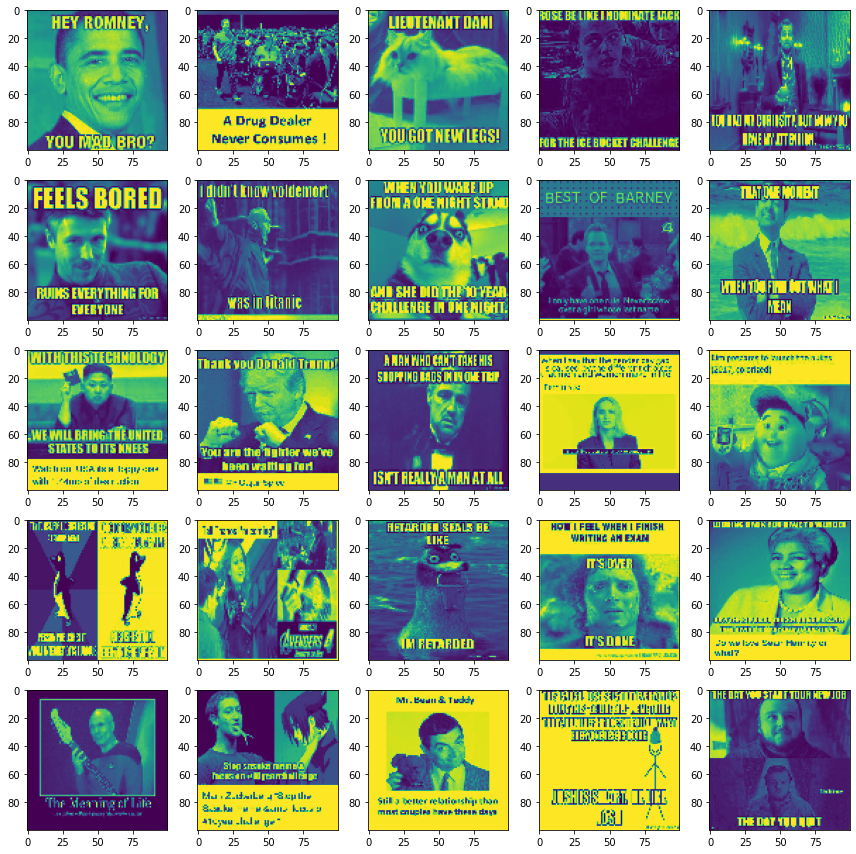

In [27]:
fig, axes = plt.subplots(5,5, figsize=(12, 12))

for i in range(5):
    for j in range(5):
        index = np.random.randint(X.shape[0])
        axes[i][j].imshow(X[index,:,:,0])
        #axes[i][j].set_title(f'Label={y_train[index]}')
        #axes[i][j].axis('off')
        plt.tight_layout()

In [28]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

preprocess_input = tf.keras.applications.resnet_v2.preprocess_input

rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)

In [29]:
base_model_1 = tf.keras.applications.ResNet50(input_shape=X[0].shape,
                                               include_top=False,
                                               weights='imagenet')
base_model_2 = tf.keras.applications.VGG16(input_shape=X[0].shape,
                                               include_top=False,
                                               weights='imagenet')

58889256/58889256 [==============================] - 4s 0us/step


In [30]:
base_model_1.trainable = False
base_model_2.trainable = False

In [31]:
global_average_layer = GlobalAveragePooling2D()

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2)

In [33]:
del X

In [34]:
image_input = tf.keras.Input(shape=(100, 100, 3), name = 'image_input')
iamge_layers = data_augmentation(image_input)
iamge_layers = preprocess_input(iamge_layers)
layer_bm_1 = base_model_1(image_input, training=False)
layer_bm_1 = Conv2D(2048, kernel_size=2,padding='valid')(layer_bm_1)
layer_bm_1 = Dense(512)(layer_bm_1)
layer_bm_2 = base_model_2(image_input, training=False)
layer_bm_2 = Dense(512)(layer_bm_2)
layers = tf.keras.layers.concatenate([layer_bm_1, layer_bm_2])
iamge_layers = global_average_layer(layer_bm_1)
image_layers = Dropout(0.2, name = 'dropout_layer')(iamge_layers)

In [35]:
def standardization(data):
    data = data.apply(lambda x: x.lower())
    data = data.apply(lambda x: re.sub(r'\d+', '', x))
    data = data.apply(lambda x: re.sub(r'.com', '', x, flags=re.MULTILINE))
    data = data.apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
    return data

df['text_corrected'] = standardization(df.text_corrected)

In [36]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
vocab_size = 10000
sequence_length = 100

vectorize_layer = TextVectorization(
    max_tokens=vocab_size,
    output_mode='int',
    output_sequence_length=sequence_length)

text_ds = np.asarray(df['text_corrected'])
vectorize_layer.adapt(tf.convert_to_tensor(text_ds))

In [37]:
X_text_train, X_text_test, y_text_train, y_text_test = train_test_split(cleaner_df.text_corrected, Y, test_size = 0.2)


In [38]:
embedding_dim=16

text_input = tf.keras.Input(shape=(1,), dtype=tf.string, name='text')
text_layers = vectorize_layer(text_input)
text_layers = tf.keras.layers.Embedding(vocab_size, embedding_dim, name="embedding")(text_layers)
text_layers = tf.keras.layers.Dropout(0.5)(text_layers)

text_layers = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, activation='relu', return_sequences=True))(text_layers)

text_layers = tf.keras.layers.Conv1D(128, 7, padding="valid", activation="relu", strides=3)(text_layers)
text_layers = tf.keras.layers.Conv1D(128, 7, padding="valid", activation="relu", strides=3)(text_layers)
text_layers = tf.keras.layers.GlobalMaxPooling1D()(text_layers)

# We add a vanilla hidden layer:
text_layers = tf.keras.layers.Dense(2048, activation="relu")(text_layers)
text_layers = tf.keras.layers.Dropout(0.5)(text_layers)

In [39]:
concatenate = tf.keras.layers.concatenate([image_layers, text_layers], axis=1)

In [40]:
overall_layer = tf.keras.layers.Dense(2048, activation='softmax')(concatenate)

In [41]:
prediction_layer_1 = tf.keras.layers.Dense(4, activation='softmax', name = 'sarcasm')
prediction_layer_2 = tf.keras.layers.Dense(4, activation='softmax', name = 'humuor')
prediction_layer_3 = tf.keras.layers.Dense(4, activation='softmax', name = 'offensive')
prediction_layer_4 = tf.keras.layers.Dense(1, activation='sigmoid', name = 'motivational')
prediction_layer_5 = tf.keras.layers.Dense(5, activation='softmax', name = 'overall')

In [42]:
output_1 = prediction_layer_1(overall_layer)
output_2 = prediction_layer_2(overall_layer)
output_3 = prediction_layer_3(overall_layer)
output_4 = prediction_layer_4(overall_layer)
output_5 = prediction_layer_5(overall_layer)
model = tf.keras.Model(inputs = [image_input, text_input] , outputs = [output_1, output_2, output_3, output_4, output_5])

In [43]:
!pip install tensorflow-addons -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 48.2 MB/s eta 0:00:00


In [44]:
import tensorflow_addons as tfa

In [45]:
base_learning_rate = 0.01
losses = {
      "humuor": tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
      "sarcasm": tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
      "offensive": tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
      "motivational": tf.keras.losses.BinaryCrossentropy(from_logits=False),
      "overall": tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
}
lossWeights = {
      "humuor": 1.0, 
      "sarcasm": 1.0, 
      "offensive": 1.0, 
      "motivational": 1.0,
      "overall": 1.0
}
metric = {
    "humuor": ['acc',tfa.metrics.F1Score(num_classes=4, average="micro", threshold = 0.9)],
    "sarcasm": ['acc',tfa.metrics.F1Score(num_classes=4, average="micro", threshold = 0.9)],
    "offensive": ['acc',tfa.metrics.F1Score(num_classes=4, average="micro", threshold = 0.9)],
    "motivational": ['acc',tfa.metrics.F1Score(num_classes=1, average="micro", threshold = 0.9)],
    "overall": ['acc',tfa.metrics.F1Score(num_classes=5, average="micro", threshold = 0.9)]
}
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss = losses,
              loss_weights= lossWeights,
              metrics=metric)

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [47]:
learning_rates = [0.1] #, 0.01, 0.001, 0.0001, 0.00001]
for i in learning_rates:
    model.compile(optimizer=tf.keras.optimizers.RMSprop(i),
              loss = losses,
              loss_weights= lossWeights,
              metrics=['accuracy'])
    
    history = model.fit(x = {"image_input": X_train, "text": X_text_train},
                    y = {"sarcasm": y_train.sarcasm, 
                         "humuor": y_train.humour, 
                         "offensive": y_train.offensive, 
                         "motivational": y_train.motivational, 
                         "overall": y_train.overall_sentiment},
                    batch_size=32,
                    epochs=2, #50
                    verbose=2
                   )

Epoch 1/2
175/175 - 103s - loss: 5.6505 - sarcasm_loss: 1.1958 - humuor_loss: 1.3134 - offensive_loss: 1.1922 - motivational_loss: 0.6559 - overall_loss: 1.2931 - sarcasm_accuracy: 0.4972 - humuor_accuracy: 0.3295 - offensive_accuracy: 0.3850 - motivational_accuracy: 0.6455 - overall_accuracy: 0.4310 - 103s/epoch - 589ms/step
Epoch 2/2
175/175 - 73s - loss: 5.6468 - sarcasm_loss: 1.1960 - humuor_loss: 1.3151 - offensive_loss: 1.1893 - motivational_loss: 0.6562 - overall_loss: 1.2902 - sarcasm_accuracy: 0.4965 - humuor_accuracy: 0.3287 - offensive_accuracy: 0.3826 - motivational_accuracy: 0.6455 - overall_accuracy: 0.4294 - 73s/epoch - 416ms/step


In [48]:
pd.DataFrame(history.history)

,loss,sarcasm_loss,humuor_loss,offensive_loss,motivational_loss,overall_loss,sarcasm_accuracy,humuor_accuracy,offensive_accuracy,motivational_accuracy,overall_accuracy
0,5.650484,1.195845,1.313447,1.192218,0.655891,1.293084,0.497225,0.329454,0.384960,0.645479,0.430976
1,5.646822,1.195977,1.315086,1.189287,0.656240,1.290231,0.496509,0.328738,0.382632,0.645479,0.429364


In [49]:
evaluate = model.evaluate(x = {"image_input": X_test, "text": X_text_test},
                    y = {"sarcasm": y_test.sarcasm, 
                         "humuor": y_test.humour, 
                         "offensive": y_test.offensive, 
                         "motivational": y_test.motivational, 
                         "overall": y_test.overall_sentiment},
                    batch_size=32,
                    verbose=2
                   )

/usr/local/lib/python3.8/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


44/44 - 6s - loss: 5.6660 - sarcasm_loss: 1.1663 - humuor_loss: 1.3226 - offensive_loss: 1.2137 - motivational_loss: 0.6477 - overall_loss: 1.3157 - sarcasm_accuracy: 0.5068 - humuor_accuracy: 0.3436 - offensive_accuracy: 0.3486 - motivational_accuracy: 0.6550 - overall_accuracy: 0.4452 - 6s/epoch - 130ms/step
